In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

# Подготовка данных <a name='preparing'></a>

Source: [Physics vs Chemistry vs Biology](https://www.kaggle.com/datasets/vivmankar/physics-vs-chemistry-vs-biology)

In [2]:
train_df = pd.read_csv('./phi_che_bio/train.csv')
test_df = pd.read_csv('./phi_che_bio/test.csv')

In [3]:
train_df.head()

,Id,Comment,Topic
0,0x840,A few things. You might have negative- frequen...,Biology
1,0xbf0,Is it so hard to believe that there exist part...,Physics
2,0x1dfc,There are bees,Biology
3,0xc7e,I'm a medication technician. And that's alot o...,Biology
4,0xbba,Cesium is such a pretty metal.,Chemistry


In [12]:
total_df = pd.concat([train_df, test_df])
total_df.shape

(10281, 3)

In [13]:
total_df.groupby(by='Topic').count()

,Id,Comment
Topic,,
Biology,4205,4205
Chemistry,3426,3426
Physics,2650,2650


In [19]:
raw_data = total_df[total_df.Topic == 'Biology']['Comment'].values
raw_data.shape

(4205,)

In [20]:
n_topics = 8

# Preparing data

In [21]:
vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True) 
input_matrix = vectorizer.fit_transform(raw_data).todense()

In [22]:
vocab = vectorizer.get_feature_names_out()
vocab.shape

(12026,)

In [23]:
input_matrix.shape

(4205, 12026)

In [25]:
input_matrix = np.asarray(input_matrix)

# SVD

In [26]:
svd_modeling = TruncatedSVD(n_components=n_topics, random_state=122)

In [60]:
%timeit svd_modeling.fit(input_matrix)

2.32 s ± 51.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
svd_modeling = svd_modeling.fit(input_matrix)

In [28]:
components = svd_modeling.components_

In [29]:
components.shape

(8, 12026)

# NMF

In [30]:
NMF_model = NMF(n_components=n_topics, random_state=122)

In [59]:
%timeit NMF_model.fit_transform(input_matrix)

15 s ± 1.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
W = NMF_model.fit_transform(input_matrix)

In [32]:
H = NMF_model.components_

In [33]:
input_matrix.shape, W.shape, H.shape

((4205, 12026), (4205, 8), (8, 12026))

# Comparing

In [34]:
def get_topics(voc, comps): 
    topic_word_list = []
    
    for i, comp in enumerate(comps):
        terms_comp = zip(voc, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)
        len_topic = len(sorted_terms)
        topic = ' '.join([t[0] for t in sorted_terms[:20]])
        print(f'Topic {i + 1}')
        print('\t', topic, '\n')
        topic_word_list.append(topic)
    
    return topic_word_list

In [35]:
svd_topics_list = get_topics(vocab, components)

Topic 1
	 like don just know thank looks people think eat bug really good sure life ve thanks ll want things doesn 

Topic 2
	 thank ideas good appreciate websites checking sense great asap explanation helpful reminding sharing needed makes reply friend ton youu helps 

Topic 3
	 cream ice like looks forbidden strawberry bug assassin vanilla thought icecream scoop thank candy cotton delicious taste shit june dead 

Topic 4
	 like looks bug assassin wheel bugs june dead thank mushroom type chagas lol bite sounds wheelbug naughty kind pistachio hungry 

Topic 5
	 deleted comment like thanks thing thought nigga downvoted got die let dude called looks https flesh burning silly reddit nbut 

Topic 6
	 bug assassin wheel don bugs kind type know ice cream forbidden bite wheelbug aka deleted assasin strawberry family cool species 

Topic 7
	 eat don know mushroom magic amanita mushrooms poisonous muscaria wanted powers mario deleted dare eating thank happens thought absorb ll 

Topic 8
	 thank

In [36]:
nmf_topics_list = get_topics(vocab, H)

Topic 1
	 just don know people think really life way question covid probably ve sure time say good things make yes doesn 

Topic 2
	 thank ideas good appreciate sense great makes websites checking explanation asap helpful needed friend sharing reminding really reply looking ton 

Topic 3
	 like looks mushroom look seen does sounds dead thought lol taste deep love naughty mario frog pistachio doesn ass spider 

Topic 4
	 cream ice forbidden strawberry vanilla icecream scoop thought cotton candy shit bruh swirl neapolitan delicious duh forbiddenfoods neopolitan cake forbiddensnacks 

Topic 5
	 deleted comment nigga downvoted dude die thing let called got flesh silly burning nbut short just day stupid jesus anxiety 

Topic 6
	 bug assassin wheel bugs kind type bite wheelbug aka family cool assasin chagas sting reduviidae june species painful mentioned kissing 

Topic 7
	 eat mushroom don magic amanita mushrooms lol muscaria poisonous ll kill wanted powers said dare rest mario absorb yes h

In [37]:
def print_topics_cloud(curr_topics_list):
    n_rows, n_cols = 2, 4
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(50, 20))
    for i in range(n_topics):
          wc = WordCloud(width=1000, height=1000, margin=1,  prefer_horizontal=0.7,scale=1,background_color='white', relative_scaling=0).generate(curr_topics_list[i])
          row = i // n_cols
          col = i % n_cols
          ax[row][col].imshow(wc)
          ax[row][col].axis("off")
    
    plt.show()

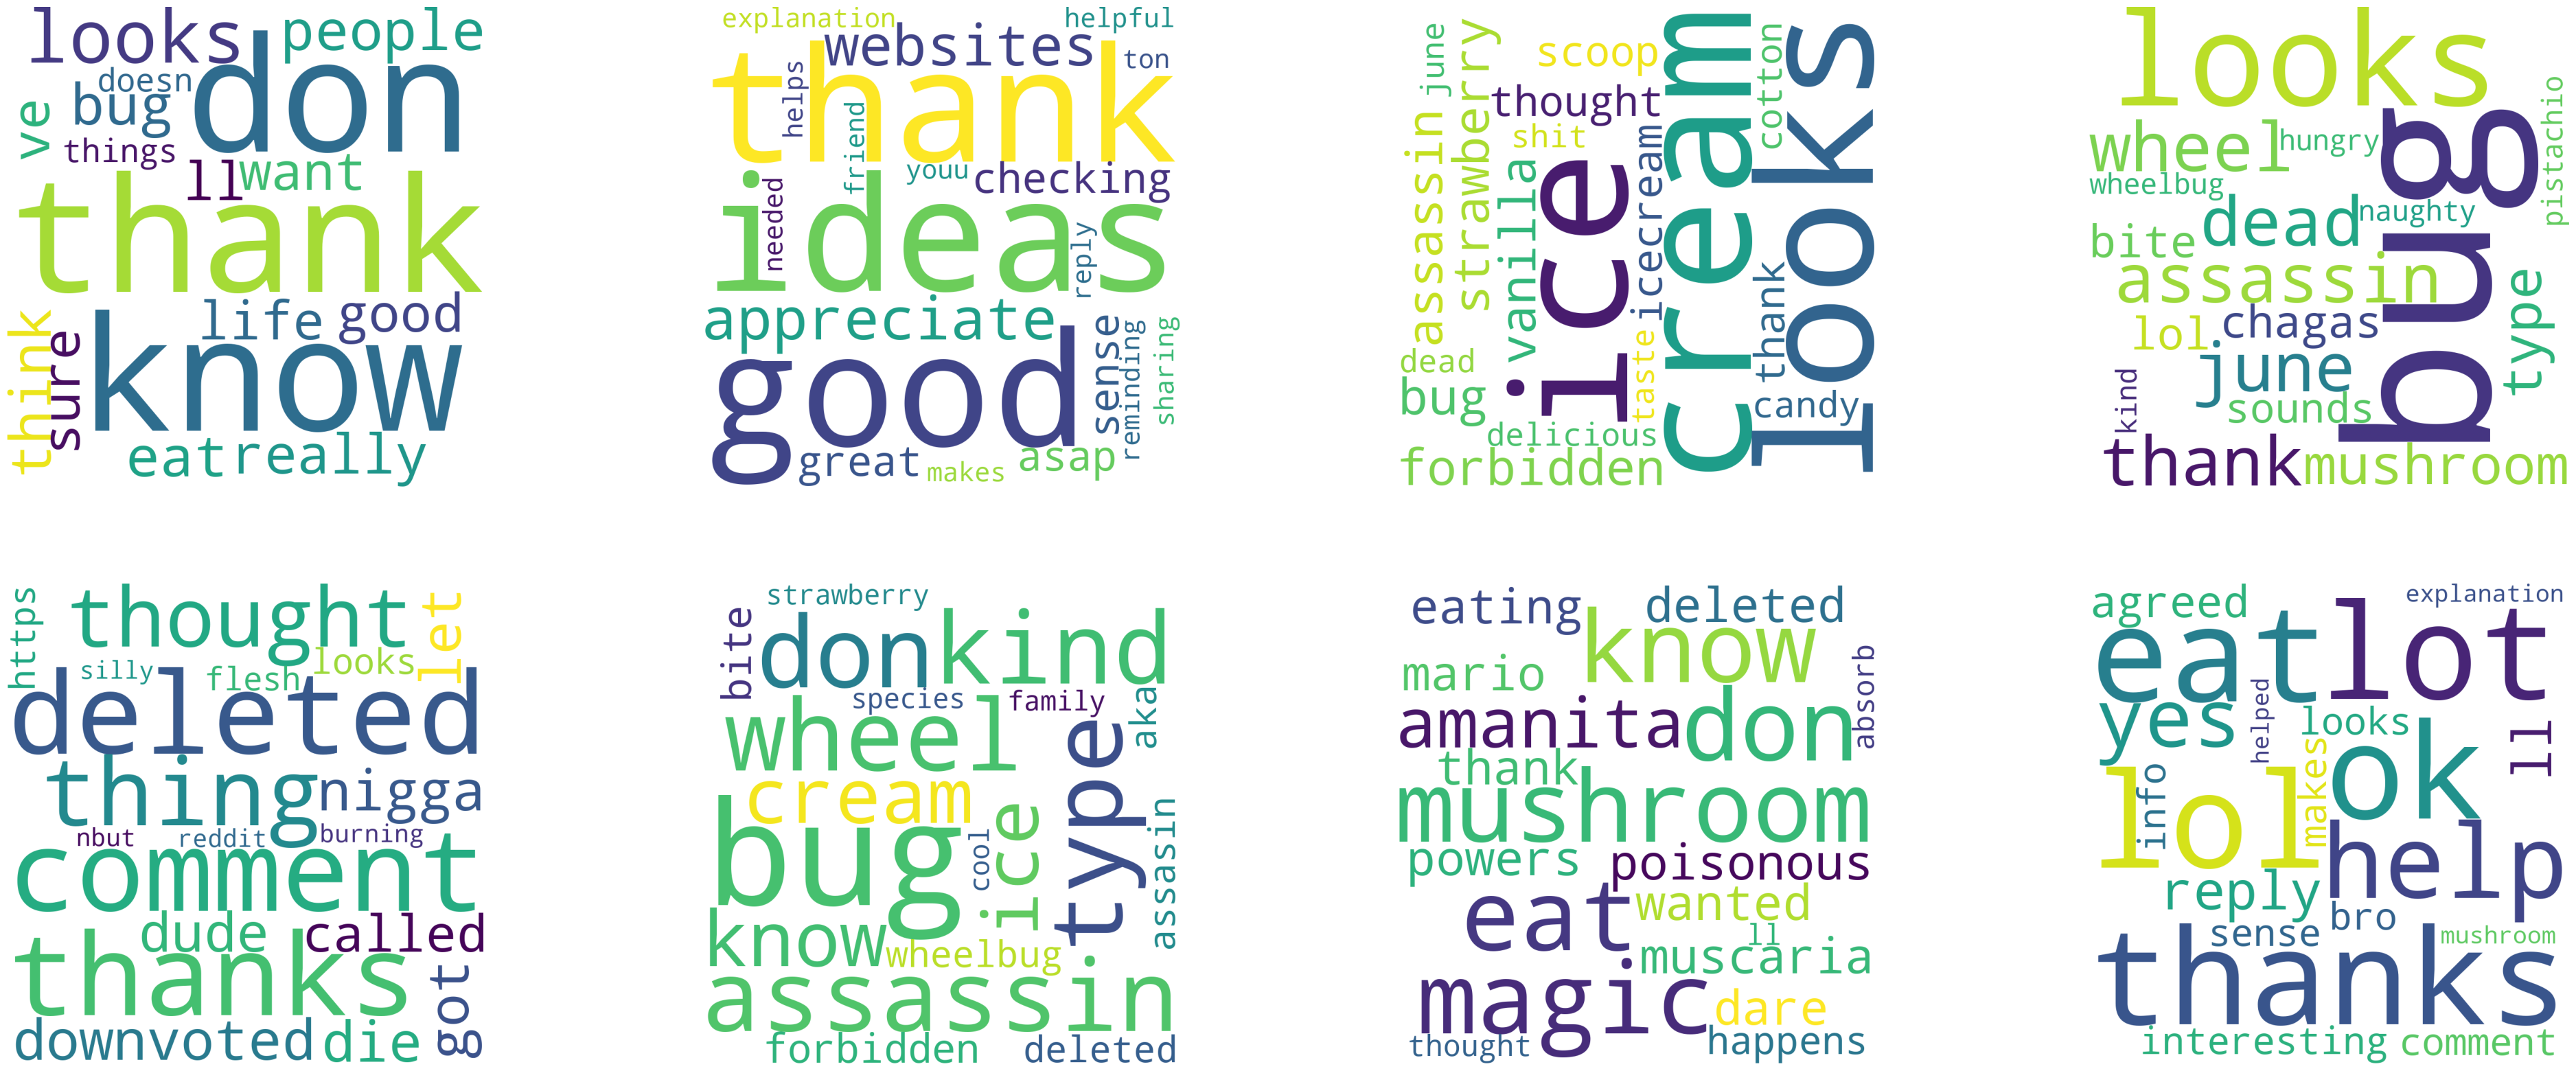

In [38]:
print_topics_cloud(svd_topics_list)

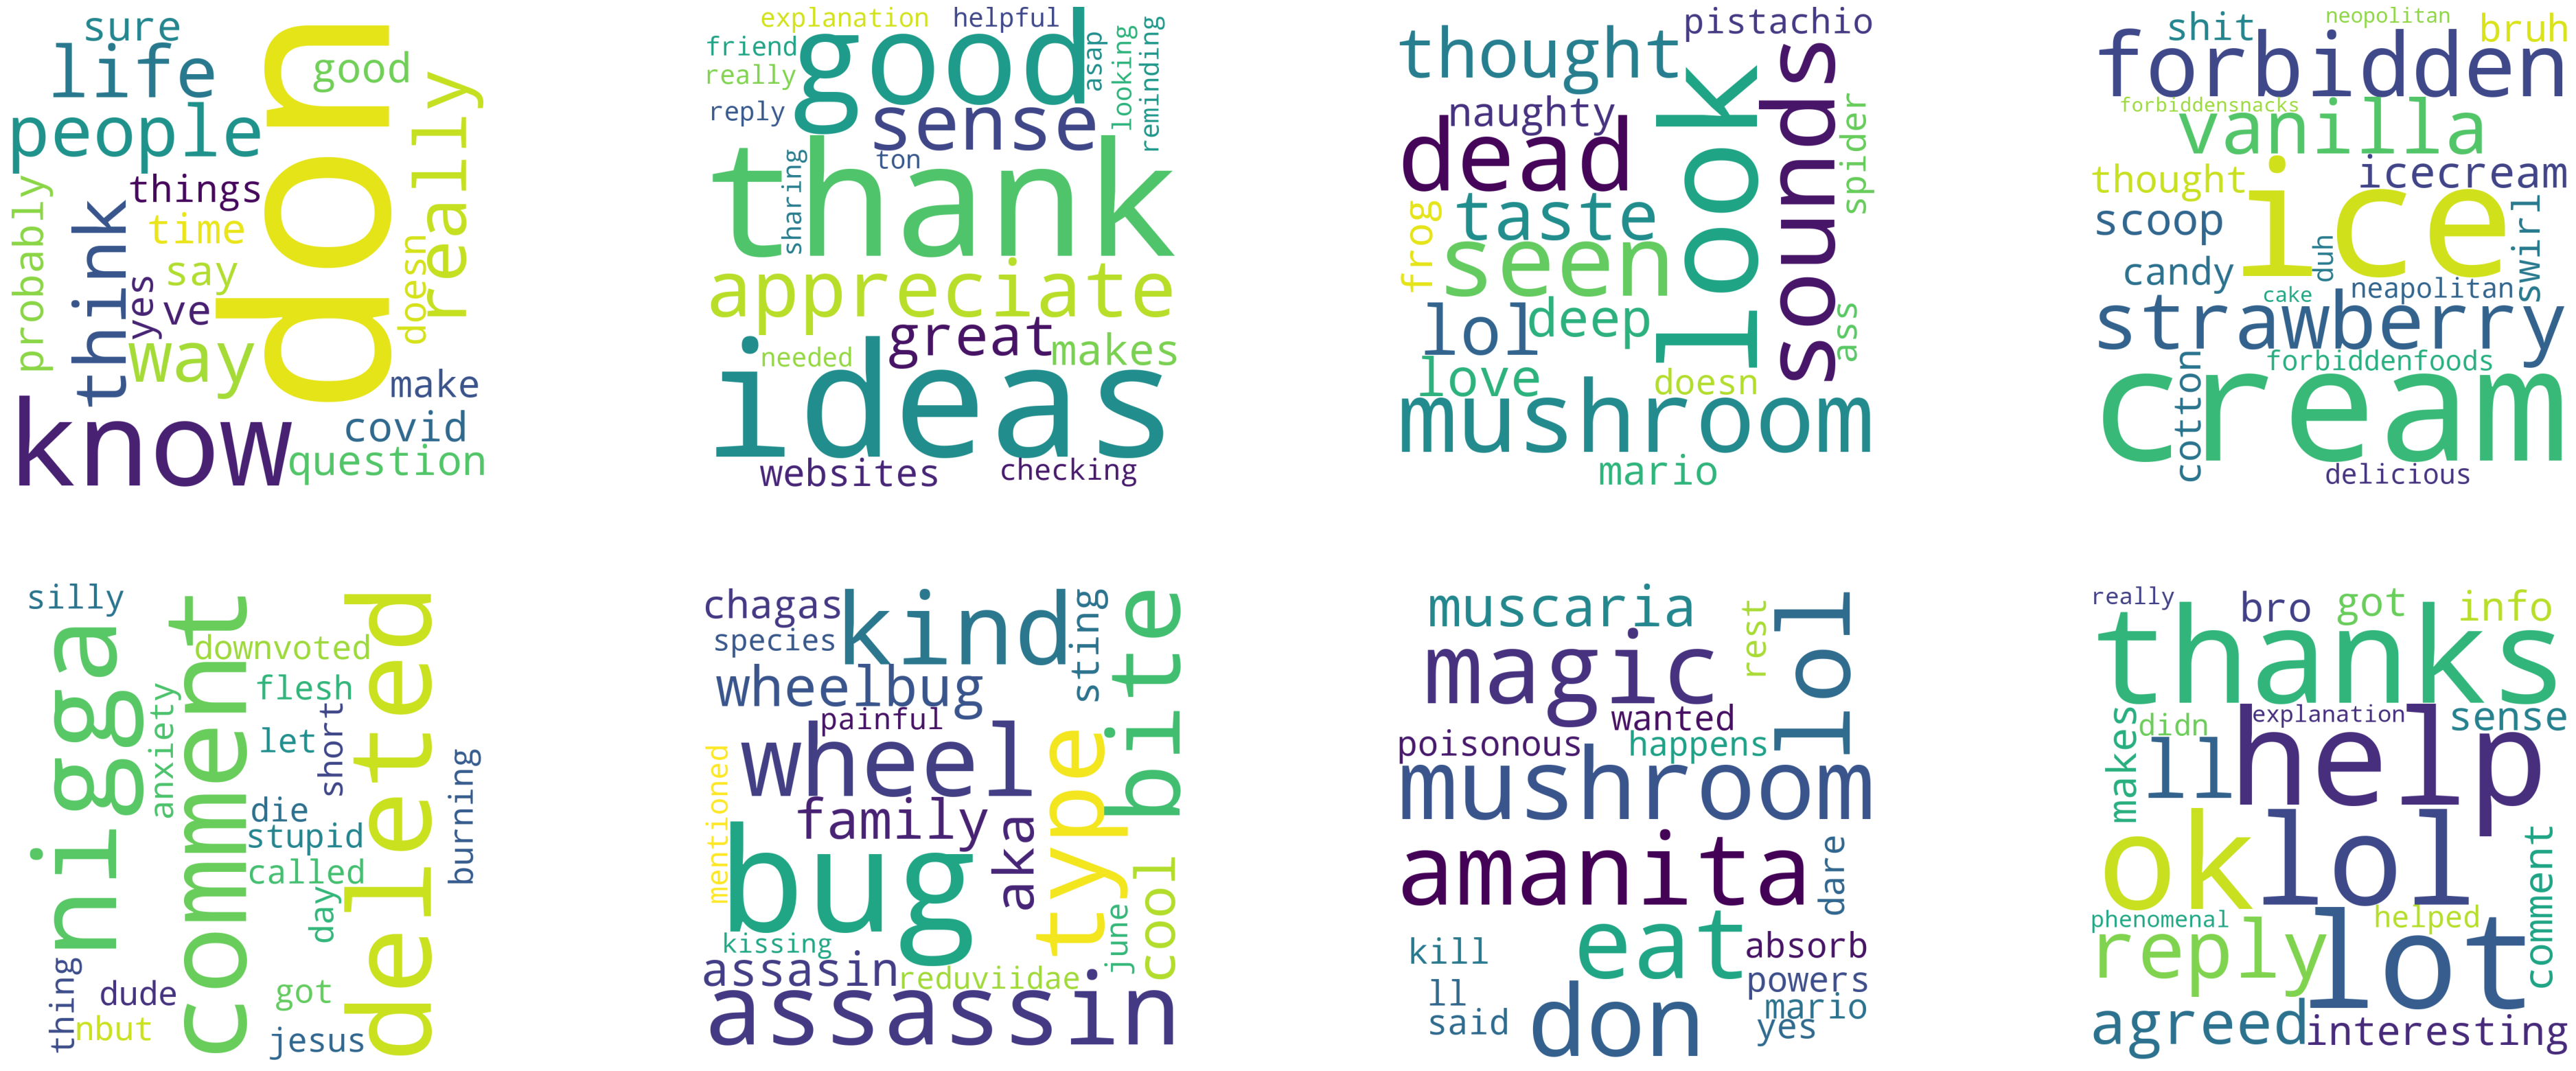

In [39]:
print_topics_cloud(nmf_topics_list)

In [61]:
n_comps = range(1, 11)
svd_times = []
nmf_times = []

for comp in n_comps:
    svd_modeling = TruncatedSVD(n_components=comp, random_state=122)
    st = time.time()
    svd_modeling.fit(input_matrix)
    ft = time.time() - st
    svd_times.append(ft)

for comp in n_comps:
    NMF_model = NMF(n_components=n_topics, random_state=122)
    st = time.time()
    NMF_model.fit(input_matrix)
    ft = time.time() - st
    nmf_times.append(ft)


In [54]:
len(list(n_comps)), len(svd_times), len(nmf_times)

(10, 10, 10)

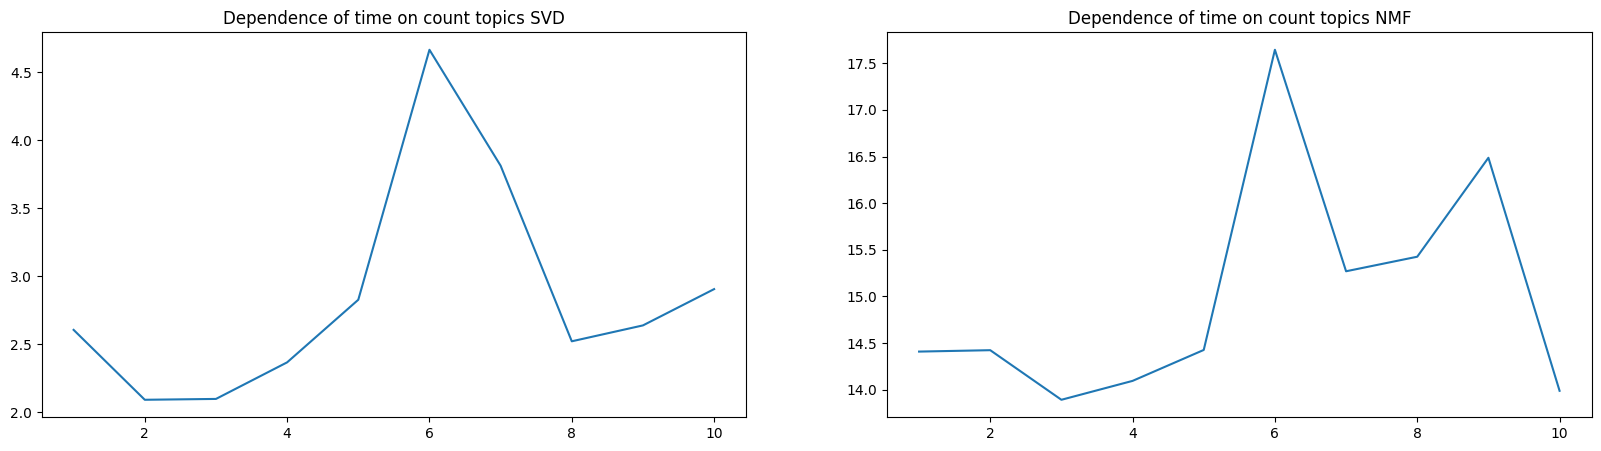

In [57]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(n_comps, svd_times)
plt.title('Dependence of time on count topics SVD')

plt.subplot(122)
plt.plot(n_comps, nmf_times)
plt.title('Dependence of time on count topics NMF')

plt.show()

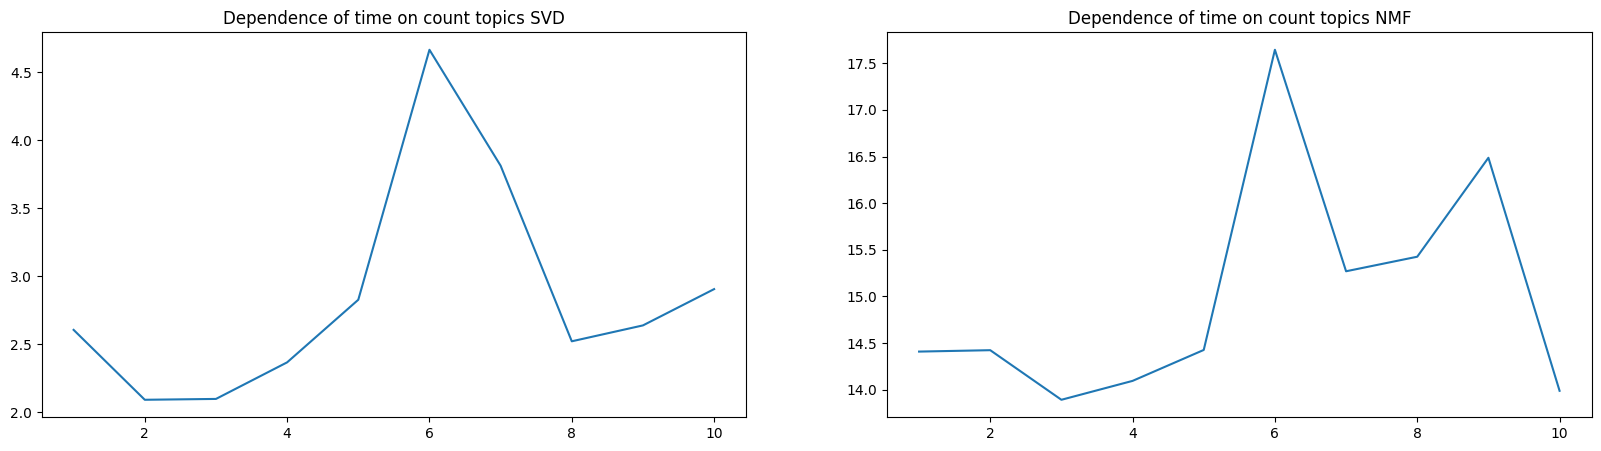

In [58]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(n_comps, svd_times)
plt.title('Dependence of time on count topics SVD')

plt.subplot(122)
plt.plot(n_comps, nmf_times)
plt.title('Dependence of time on count topics NMF')

plt.show()

Описание работы методов: [topic modeling](https://www.freecodecamp.org/news/advanced-topic-modeling-how-to-use-svd-nmf-in-python/)
